In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('max_columns', None)
import datetime
import math, time

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, LSTM, GRU
from tensorflow.keras.optimizers import Adam,RMSprop,SGD

In [3]:
stocks_df = pd.read_csv("/kaggle/input/nyse/prices-split-adjusted.csv",index_col=0)
firm_df = pd.read_csv("/kaggle/input/nyse/securities.csv",header=0)

In [4]:
stocks_df.head(10)

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0
2016-01-13,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0
2016-01-14,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0
2016-01-15,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0


In [5]:
firm_df.head(10)

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877
5,AYI,Acuity Brands Inc,reports,Industrials,Electrical Components & Equipment,"Atlanta, Georgia",2016-05-03,1144215
6,ADBE,Adobe Systems Inc,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343
7,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",2015-07-09,1158449
8,AES,AES Corp,reports,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",NaN,874761
9,AET,Aetna Inc,reports,Health Care,Managed Health Care,"Hartford, Connecticut",1976-06-30,1122304


In [6]:
stocks_df.isnull().sum()

symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [7]:
firm_df.isnull().sum()

Ticker symbol                0
Security                     0
SEC filings                  0
GICS Sector                  0
GICS Sub Industry            0
Address of Headquarters      0
Date first added           198
CIK                          0
dtype: int64

In [8]:
symbols = list(set(stocks_df.symbol))
len(symbols)

501

In [9]:
symbols[:10]

['AON', 'ULTA', 'PRGO', 'GPC', 'BHI', 'CCL', 'FISV', 'JBHT', 'NRG', 'FBHS']

In [10]:
firm_df.loc[firm_df.Security.str.startswith('Micro'),:]

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
304,MCHP,Microchip Technology,reports,Information Technology,Semiconductors,"Chandler, Arizona",2007-09-07,827054
305,MU,Micron Technology,reports,Information Technology,Semiconductors,"Boise, Idaho",1994-09-27,723125
306,MSFT,Microsoft Corp.,reports,Information Technology,Systems Software,"Redmond, Washington",1994-06-01,789019


In [11]:
stocks_msft = stocks_df[stocks_df.symbol == 'MSFT']

In [12]:
stocks_msft.head(10)

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,MSFT,30.620001,30.950001,30.590000,31.100000,38409100.0
2010-01-05,MSFT,30.850000,30.959999,30.639999,31.100000,49749600.0
2010-01-06,MSFT,30.879999,30.770000,30.520000,31.080000,58182400.0
2010-01-07,MSFT,30.629999,30.450001,30.190001,30.700001,50559700.0
2010-01-08,MSFT,30.280001,30.660000,30.240000,30.879999,51197400.0
2010-01-11,MSFT,30.709999,30.270000,30.120001,30.760000,68754700.0
2010-01-12,MSFT,30.150000,30.070000,29.910000,30.400000,65912100.0
2010-01-13,MSFT,30.260000,30.350000,30.010000,30.520000,51863500.0
2010-01-14,MSFT,30.309999,30.959999,30.260000,31.100000,63228100.0


In [13]:
stocks_msft.shape

(1762, 6)

Text(0, 0.5, 'prices')

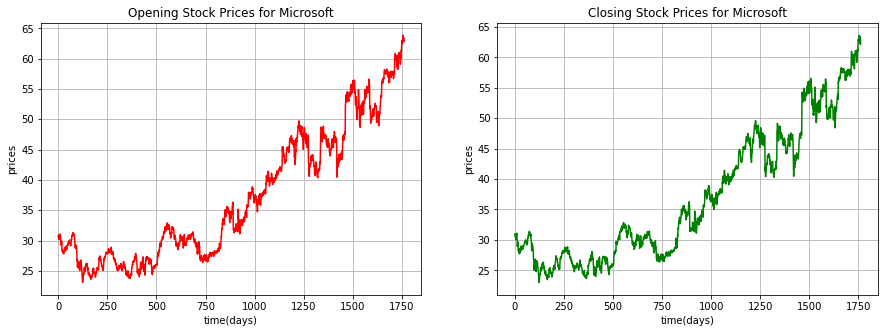

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(stocks_msft.open.values.astype('float32'),color='red',label=open)
plt.title('Opening Stock Prices for Microsoft')
plt.grid(True)
plt.xlabel('time(days)')
plt.ylabel('prices')

plt.subplot(1,2,2)
plt.plot(stocks_msft.close.values.astype('float32'),color='green',label=open)
plt.title('Closing Stock Prices for Microsoft')
plt.grid(True)
plt.xlabel('time(days)')
plt.ylabel('prices')


Text(0, 0.5, 'Volume')

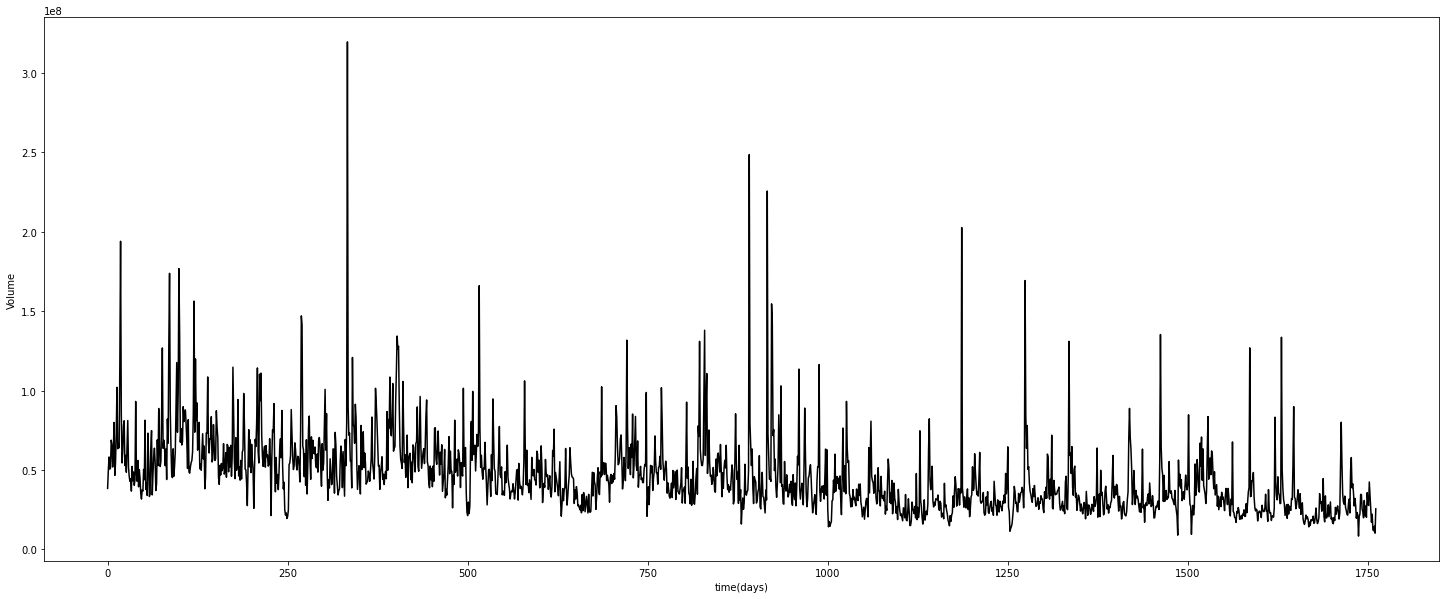

In [15]:
plt.figure(figsize=(25,10))
plt.plot(stocks_msft.volume.values,color='black')
plt.xlabel('time(days)')
plt.ylabel('Volume')

In [16]:
# fix random seed for reproducibility
np.random.seed(7)

In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

**LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.**

In [18]:
msft = stocks_msft.copy()
#msft = msft.drop('symbol',axis=1)
closing = msft.close.values
closing = closing.reshape(len(closing),1)

#normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
closing = scaler.fit_transform(closing)

In [19]:
# split into train and test sets
train_size = int(len(closing) * 0.75)
test_size = len(closing) - train_size

In [20]:
print(train_size , test_size)

1321 441


In [21]:
train, test = closing[0:train_size,:], closing[train_size:len(closing),:]

In [22]:
print(train)
print("\n ----------------------------")
print(test)

[[0.19551837]
 [0.19576457]
 [0.19108594]
 ...
 [0.43462202]
 [0.43609952]
 [0.42551099]]

 ----------------------------
[[0.45653779]
 [0.4560453 ]
 [0.45333658]
 [0.4548141 ]
 [0.460724  ]
 [0.4617089 ]
 [0.45900031]
 [0.47402114]
 [0.47155874]
 [0.4582615 ]
 [0.4900271 ]
 [0.48337847]
 [0.49199711]
 [0.50061562]
 [0.61216448]
 [0.6161044 ]
 [0.64393008]
 [0.64146766]
 [0.63112533]
 [0.63161784]
 [0.62127561]
 [0.60551585]
 [0.57301156]
 [0.58335389]
 [0.60920957]
 [0.59985224]
 [0.59935973]
 [0.60625466]
 [0.63309534]
 [0.62275301]
 [0.61561188]
 [0.60502346]
 [0.60502346]
 [0.60108344]
 [0.58827881]
 [0.58064518]
 [0.60576217]
 [0.60182225]
 [0.58729381]
 [0.59640484]
 [0.5887712 ]
 [0.58704749]
 [0.57498157]
 [0.56956414]
 [0.55946813]
 [0.55749822]
 [0.58113769]
 [0.57695148]
 [0.56537802]
 [0.55331201]
 [0.56193062]
 [0.56537802]
 [0.58384638]
 [0.56857913]
 [0.57178036]
 [0.56390053]
 [0.5572519 ]
 [0.55749822]
 [0.54789457]
 [0.52597881]
 [0.5205615 ]
 [0.52794882]
 [0.5267176

In [29]:
# reshape into X=t and Y=t+1
look_back = 1   # Taking 1 past values to predict a single value
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

Since our data is in the form of sample and features , we need to convert it to the form of [sample,timestamp,features]

In [30]:
# reshape input to be [samples, time steps, features]
#Timestamp here is taken as 1 ie looking at the stock of time t we will predict at t+1
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [31]:
trainX.shape,trainY.shape,testX.shape,testY.shape

((1319, 1, 1), (1319,), (439, 1, 1), (439,))

Now we prepare the LSTM network for predicting the 

In [47]:
#Creating a call back functionn
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.95):
            print("\n Reaching 95% so stopping the training now")
            self.model.stop_training = True
            
callbacks = myCallback()

In [49]:
filepath = 'weights'
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,monitor = 'val_accuracy', verbose=0, save_freq='epoch',save_best_only=True)

In [48]:
lr_platue = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,patience=5,verbose=0,mode='max')

In [63]:
def build_model():
    
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(1, look_back), return_sequences=True))
    model.add(Dropout(0.4))
        
    model.add(LSTM(256))
    model.add(Dropout(0.4))
        
    model.add(Dense(64,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
        
    start = time.time()
    model.compile(loss='mse',optimizer=Adam(lr = 0.0005), metrics=['mean_squared_error'])
    print("Compilation Time : ", time.time() - start)
    return model

In [64]:
model = build_model()
history = model.fit(trainX,trainY,epochs=100,batch_size=128,
                   callbacks = [lr_platue,modelcheckpoint], validation_data = (testX,testY))

Compilation Time :  0.007992029190063477
Epoch 1/100
11/11 [==============================] - 1s 66ms/step - loss: 0.0783 - mean_squared_error: 0.0783 - val_loss: 0.5262 - val_mean_squared_error: 0.5262 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0772 - mean_squared_error: 0.0772 - val_loss: 0.5221 - val_mean_squared_error: 0.5221 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0760 - mean_squared_error: 0.0760 - val_loss: 0.5171 - val_mean_squared_error: 0.5171 - lr: 1.0000e-04
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0746 - mean_squared_error: 0.0746 - val_loss: 0.5111 - val_mean_squared_error: 0.5111 - lr: 1.0000e-04
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.5034 - val_mean_squared_error: 0.5034 - lr: 1.0000e-04
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - l

11/11 [==============================] - 0s 9ms/step - loss: 7.2664e-04 - mean_squared_error: 7.2664e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - lr: 1.0000e-04
Epoch 89/100
11/11 [==============================] - 0s 8ms/step - loss: 7.2887e-04 - mean_squared_error: 7.2887e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - lr: 1.0000e-04
Epoch 90/100
11/11 [==============================] - 0s 8ms/step - loss: 7.1415e-04 - mean_squared_error: 7.1415e-04 - val_loss: 8.4943e-04 - val_mean_squared_error: 8.4943e-04 - lr: 1.0000e-04
Epoch 91/100
11/11 [==============================] - 0s 8ms/step - loss: 6.5480e-04 - mean_squared_error: 6.5480e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - lr: 1.0000e-04
Epoch 92/100
11/11 [==============================] - 0s 8ms/step - loss: 7.1369e-04 - mean_squared_error: 7.1369e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - lr: 1.0000e-04
Epoch 93/100
11/11 [==============================] - 0s 8ms/step - lo

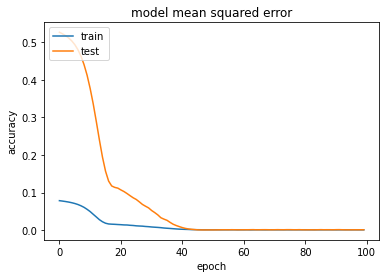

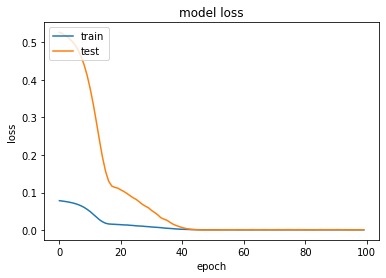

In [65]:
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, trainX, trainY , testX, testY)

Train Score: 0.00015 MSE (0.01 RMSE)
Test Score: 0.00092 MSE (0.03 RMSE)


(0.00015286281995940953, 0.0009154542349278927)

In [ ]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()